# 演習：Shorコードでの量子エラー訂正

In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.quantum_info.operators import Operator
from IPython.display import Latex

from qc_workbook.show_state import show_state

def show_circuit_op(circuit, global_phase=0.):
    op = Operator(circuit)
    
    unitary = op.data * np.exp(-1.j * global_phase)

    rows = list()
    for row_data in unitary:
        elements = list()
        for elem in row_data:
            if np.isclose(elem, 0.):
                elements.append('0')
            else:
                mod = np.abs(elem)
                arg = np.angle(elem) / np.pi
                
                mod_round = np.round(mod)
                if np.isclose(mod, mod_round):
                    modstr = f'{int(mod_round)}'
                else:
                    modstr = f'{mod:.4f}'.rstrip('0')
                    
                if np.isclose(arg, 0.):
                    elements.append(f'{modstr}')
                elif np.isclose(arg, 1.) or np.isclose(arg, -1.):
                    elements.append(f'-{modstr}')
                else:
                    if modstr == '1':
                        modstr = ''
                        
                    argstr = f'{arg:.4f}'.rstrip('0')
                    elements.append(fr'{modstr}e^{{{argstr} \pi i}}')
                    
        rows.append(' & '.join(elements))
        
    expr = r'\begin{pmatrix} ' + r' \\ '.join(rows) + r'\end{pmatrix}'

    return Latex(expr)

## CPゲート

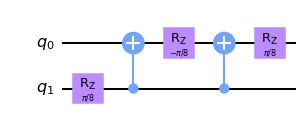

In [2]:
def apply_cp(circuit, theta, control, target):
    circuit.rz(theta / 2., control)
    circuit.cx(control, target)
    circuit.rz(-theta / 2., target)
    circuit.cx(control, target)
    circuit.rz(theta / 2., target)    

theta = np.pi / 4.

circuit = QuantumCircuit(2)

apply_cp(circuit, theta, 1, 0)

circuit.draw('mpl')

In [3]:
show_circuit_op(circuit, global_phase=-np.pi / 16.)

<IPython.core.display.Latex object>

## CCZゲート

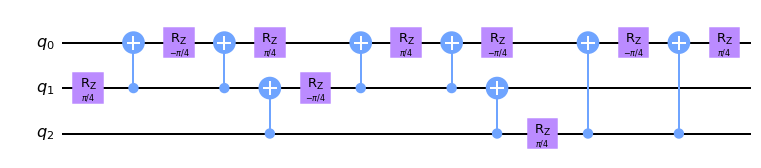

In [4]:
theta = np.pi

circuit = QuantumCircuit(3)

apply_cp(circuit, theta / 2., 1, 0)
circuit.cx(2, 1)
apply_cp(circuit, -theta / 2., 1, 0)
circuit.cx(2, 1)
apply_cp(circuit, theta / 2., 2, 0)

circuit.draw('mpl')

In [5]:
show_circuit_op(circuit, global_phase=-np.pi / 8.)

<IPython.core.display.Latex object>

## Hadamardゲート

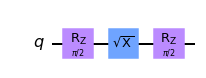

In [6]:
def apply_hadamard(circuit, qubit):
    circuit.rz(np.pi / 2., qubit)
    circuit.sx(qubit)
    circuit.rz(np.pi / 2., qubit)
    
circuit = QuantumCircuit(1)

apply_hadamard(circuit, 0)

circuit.draw('mpl')

In [7]:
show_circuit_op(circuit, global_phase=-np.pi / 4.)

<IPython.core.display.Latex object>

## Toffoliゲート

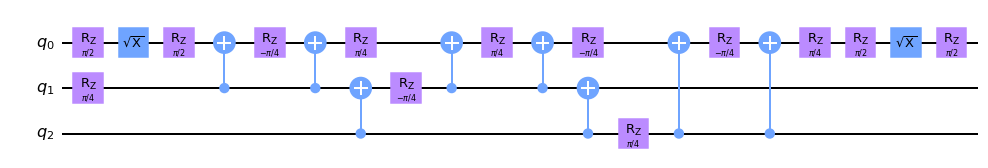

In [8]:
def apply_toffoli(circuit, control1, control2, target):
    apply_hadamard(circuit, target)
    apply_cp(circuit, np.pi / 2., control2, target)
    circuit.cx(control1, control2)
    apply_cp(circuit, -np.pi / 2., control2, target)
    circuit.cx(control1, control2)
    apply_cp(circuit, np.pi / 2., control1, target)
    apply_hadamard(circuit, target)

circuit = QuantumCircuit(3)

apply_toffoli(circuit, 2, 1, 0)

circuit.draw('mpl')

In [9]:
show_circuit_op(circuit, global_phase=(-5. / 8. * np.pi))

<IPython.core.display.Latex object>

## 量子エラーとエラー訂正

### ビット反転（$X$）エラー

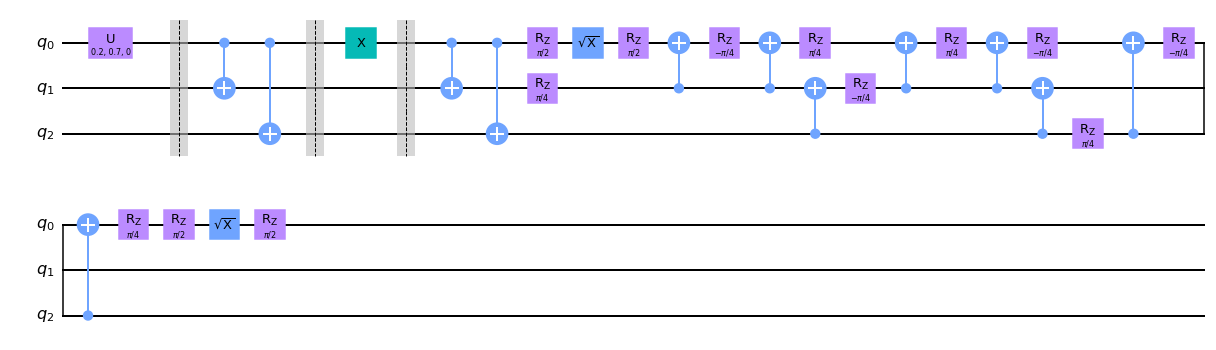

In [10]:
circuit = QuantumCircuit(3)

circuit.u(0.2, 0.7, 0., 0)
circuit.barrier()

circuit.cx(0, 1)
circuit.cx(0, 2)

circuit.barrier()
circuit.x(np.random.randint(3))
circuit.barrier()

circuit.cx(0, 1)
circuit.cx(0, 2)

apply_toffoli(circuit, 2, 1, 0)

circuit.draw('mpl')

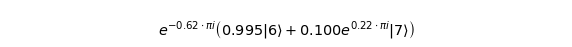

In [11]:
show_state(circuit, global_phase=(-5. / 8. * np.pi));

### 位相反転（$Z$）エラー

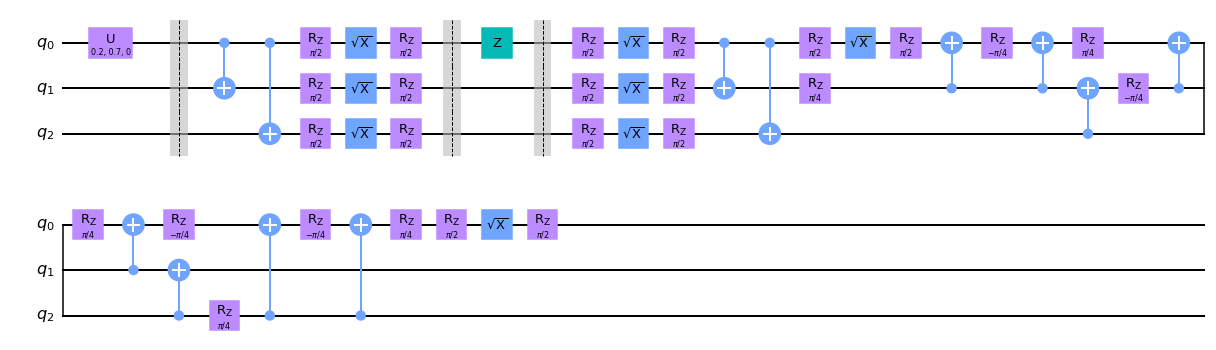

In [12]:
circuit = QuantumCircuit(3)

circuit.u(0.2, 0.7, 0., 0)
circuit.barrier()

circuit.cx(0, 1)
circuit.cx(0, 2)
apply_hadamard(circuit, [0, 1, 2])

circuit.barrier()
circuit.z(np.random.randint(3))
circuit.barrier()

apply_hadamard(circuit, [0, 1, 2])
circuit.cx(0, 1)
circuit.cx(0, 2)

apply_toffoli(circuit, 2, 1, 0)

circuit.draw('mpl')

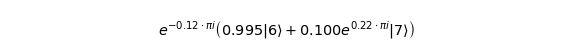

In [13]:
show_state(circuit, global_phase=-np.pi / 8.);

### Shorコード

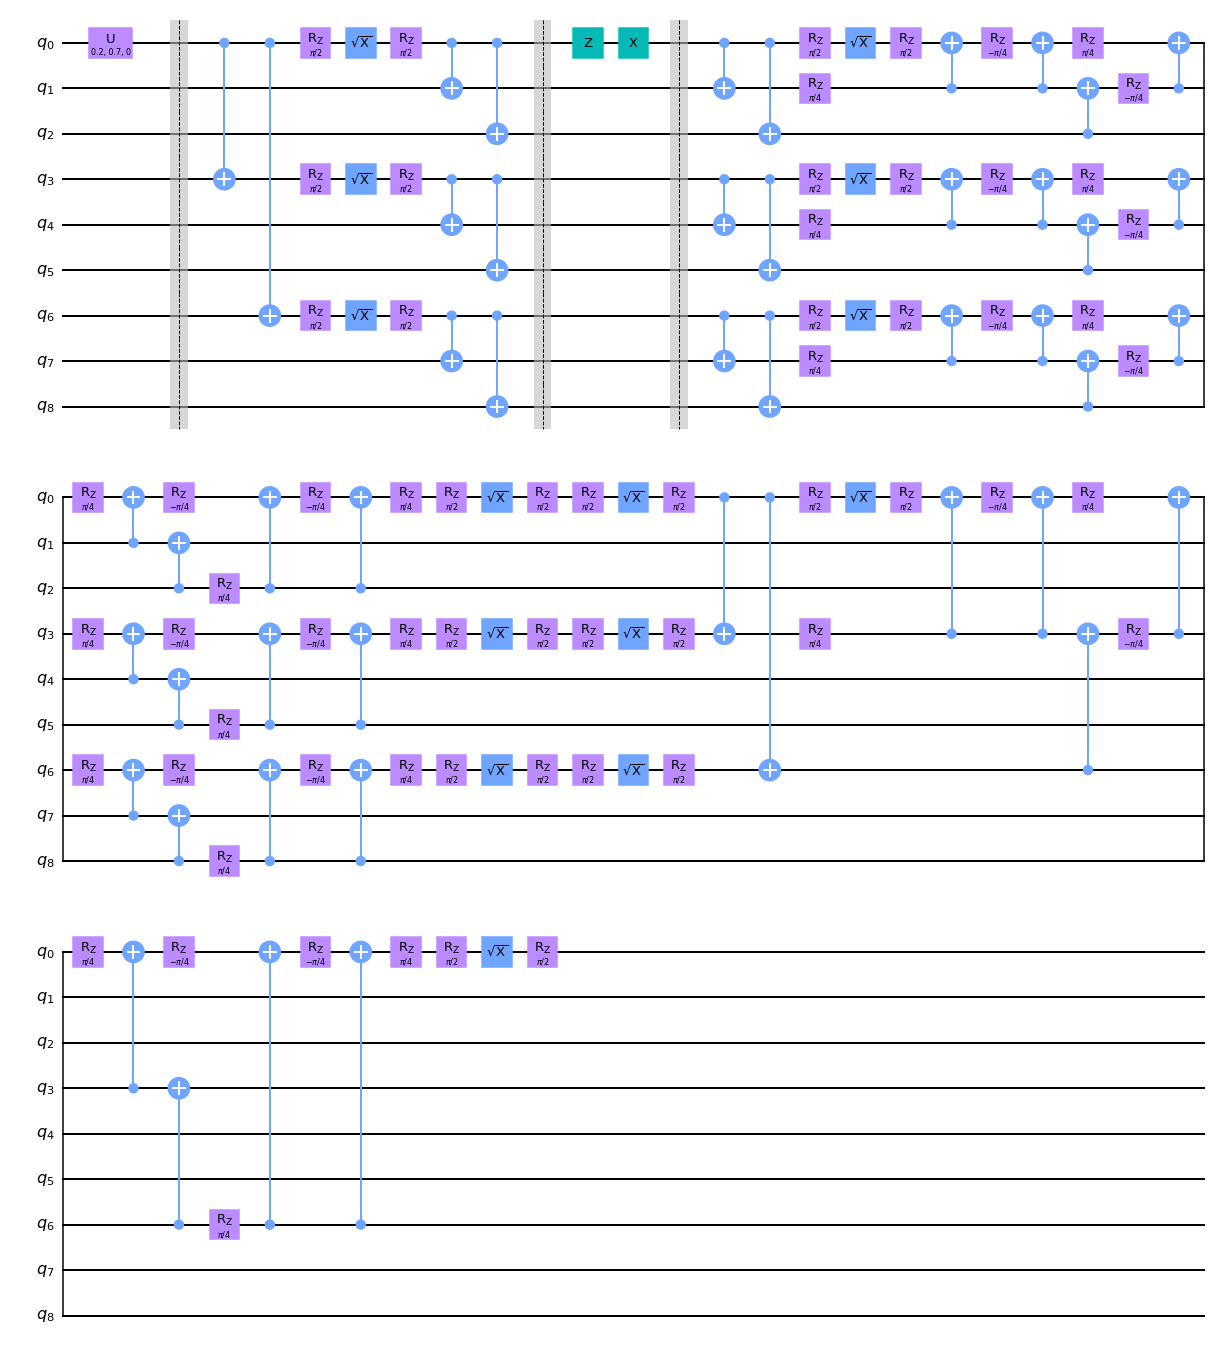

In [14]:
circuit = QuantumCircuit(9)

circuit.u(0.2, 0.7, 0., 0)
circuit.barrier()

circuit.cx(0, 3)
circuit.cx(0, 6)
apply_hadamard(circuit, [0, 3, 6])

for iq in [0, 3, 6]:
    circuit.cx(iq, iq + 1)
    circuit.cx(iq, iq + 2)

circuit.barrier()
circuit.z(np.random.randint(9))
circuit.x(np.random.randint(9))
circuit.barrier()

for iq in [0, 3, 6]:
    circuit.cx(iq, iq + 1)
    circuit.cx(iq, iq + 2)
    apply_toffoli(circuit, iq + 2, iq + 1, iq)
    
apply_hadamard(circuit, [0, 3, 6])
circuit.cx(0, 3)
circuit.cx(0, 6)

apply_toffoli(circuit, 6, 3, 0)

circuit.draw('mpl')

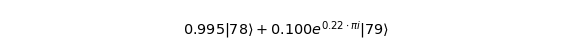

In [15]:
show_state(circuit);